In [1]:
%load_ext autoreload
%autoreload 2
import glob
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import hist

import sys
sys.path.append("..")
from dnn.ak_sample_loader import *
from dnn.torch_dataset import *
from dnn.training import *
from dnn.validation import *

In [2]:
device="cuda:0"

In [3]:
input_files = glob.glob("/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/PionSamples_v2/FixedEnergy_*.pkl")
input_samples = [AkSampleLoader.loadFromPickle(inputFile) for inputFile in input_files]
input_files

['/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/PionSamples_v2/FixedEnergy_10.pkl',
 '/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/PionSamples_v2/FixedEnergy_200.pkl',
 '/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/PionSamples_v2/FixedEnergy_300.pkl',
 '/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/PionSamples_v2/FixedEnergy_400.pkl',
 '/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/PionSamples_v2/FixedEnergy_600.pkl']

In [3]:
input_samples[0].tracksters

<Array [{regressed_energy: [], ...}, ...] type='12300 * {regressed_energy: ...'>

In [33]:
from dnn.model import *
hists = [inferenceOnSavedModel("/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/models/v4/linear/model.pt", LinearModel(len(features["feat-v2"])), input, feature_version="feat-v2", fixedEnergySample=True) for input in input_samples]

In [37]:
from dnn.model import *
hists = [inferenceOnSavedModel("/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/models/v4/mediumDNN/model.pt", MediumDNN(len(features["feat-v2"])), input, feature_version="feat-v2", fixedEnergySample=True) for input in input_samples]

In [8]:

from dnn.model import *
model = LargeDNN(len(features["feat-v2"]))
model.load_state_dict(torch.load("/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/models/v8/largeDNN/model.pt")["model_state_dict"])
hists = [inferenceOnSavedModel(None, model, input, feature_version="feat-v2", fixedEnergySample=True, device=device) for input in input_samples]

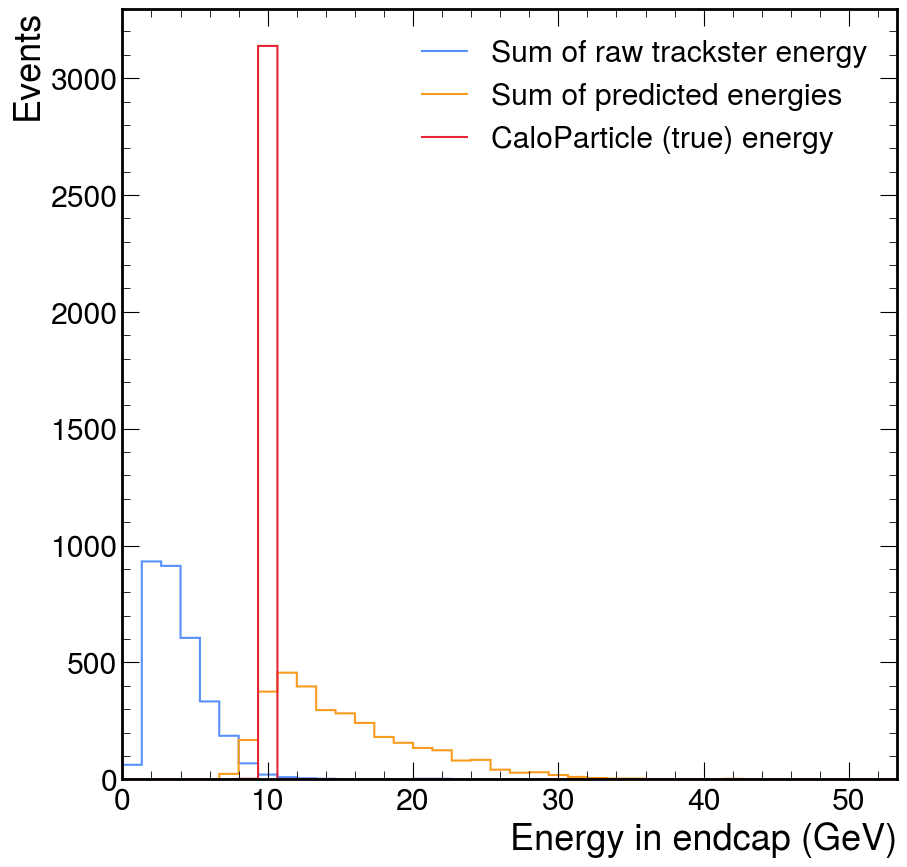

In [18]:
plotFullEnergies(hists[0], rebin=True) #["h_pred_tot_over_cp"]

In [42]:
hists[0]

{'h_pred': Hist(Regular(200, 0, 100, name='pred_energy', label='Predicted trackster energy (GeV)'), storage=Double()) # Sum: 3276.0,
 'h_reco': Hist(Regular(200, 0, 100, name='reco_energy', label='Trackster raw energy (GeV)'), storage=Double()) # Sum: 3276.0,
 'h_pred_vs_reco': Hist(
   Regular(100, 0, 100, name='reco_energy', label='Trackster raw energy (GeV)'),
   Regular(100, 0, 100, name='pred_energy', label='Predicted trackster energy (GeV)'),
   storage=Double()) # Sum: 3276.0,
 'h_reco_tot': Hist(Regular(200, 0, 800, name='reco_energy_tot', label='Total trackster raw energy (GeV)'), storage=Double()) # Sum: 3140.0,
 'h_pred_tot': Hist(Regular(200, 0, 800, name='pred_energy_tot', label='Predicted energy for full endcap (GeV)'), storage=Double()) # Sum: 3140.0,
 'h_cp': Hist(Regular(200, 0, 800, name='cp_energy', label='CaloParticle (true) energy (GeV)'), storage=Double()) # Sum: 3140.0,
 'h_reco_tot_over_cp': Hist(Regular(200, 0, 2, name='reco_tot_over_cp', label='Total trackster

/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlRegression/dnn/../dnn/fit.py:45: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)


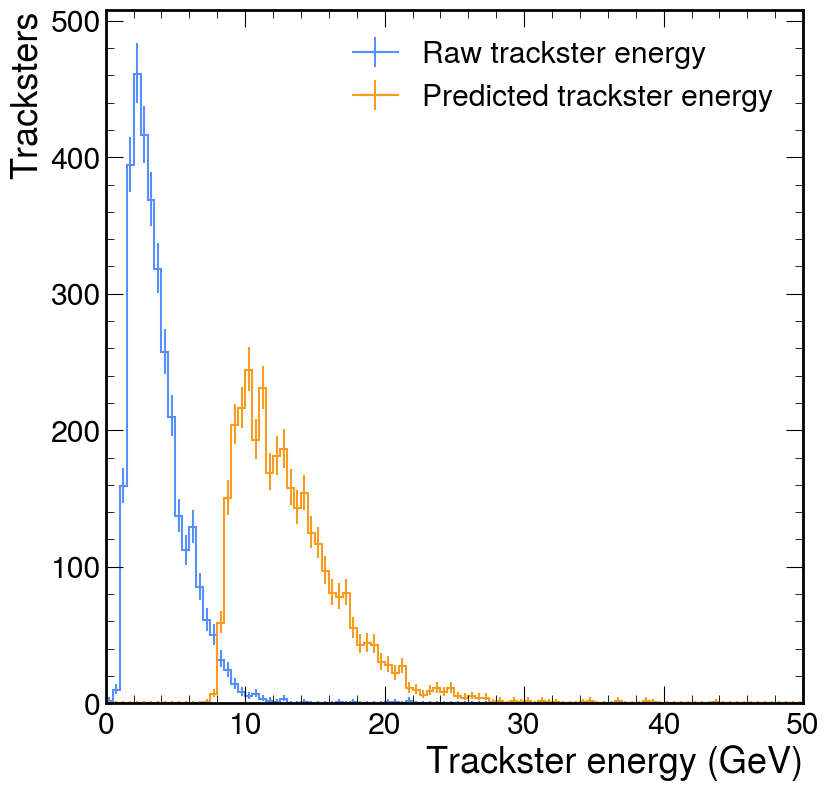

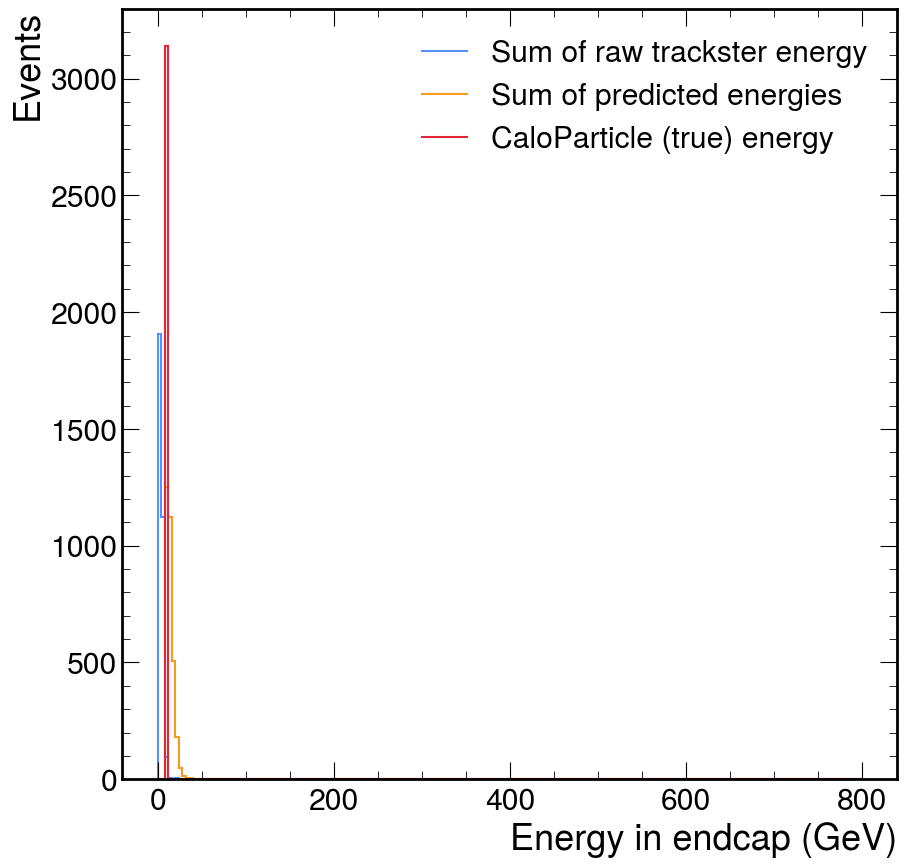

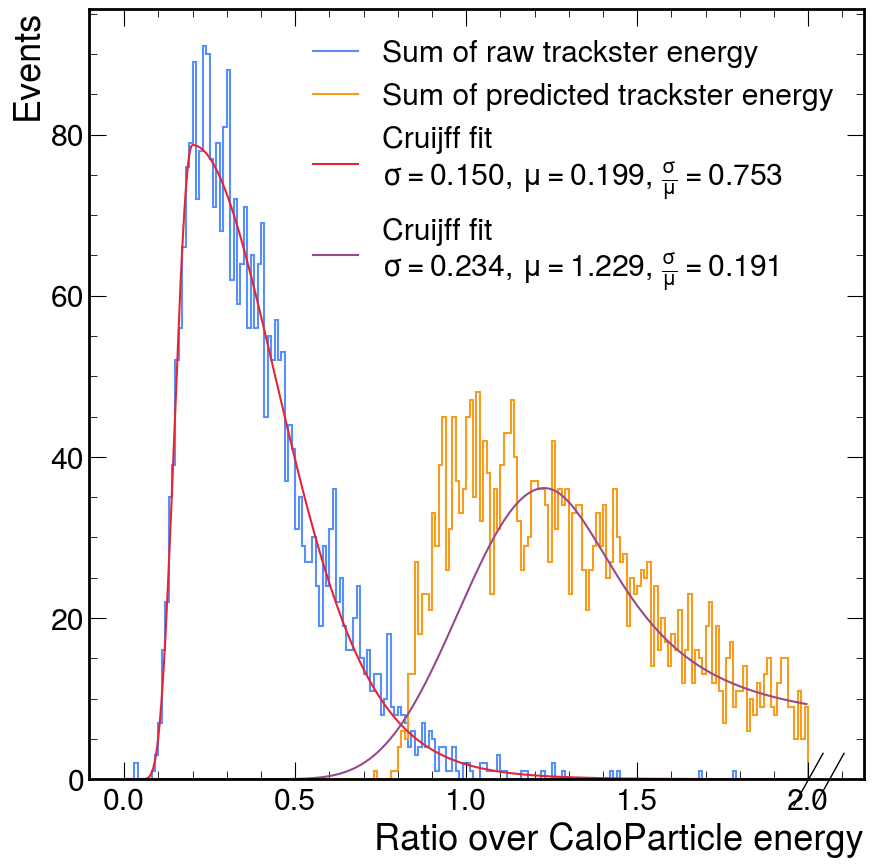

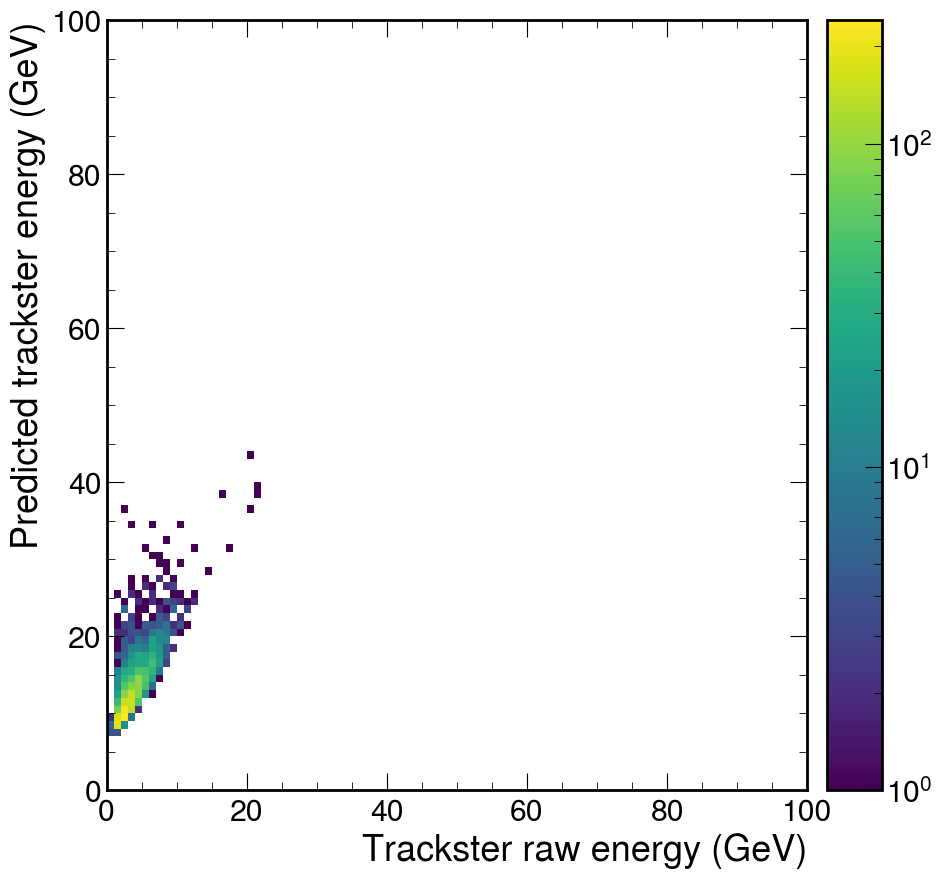

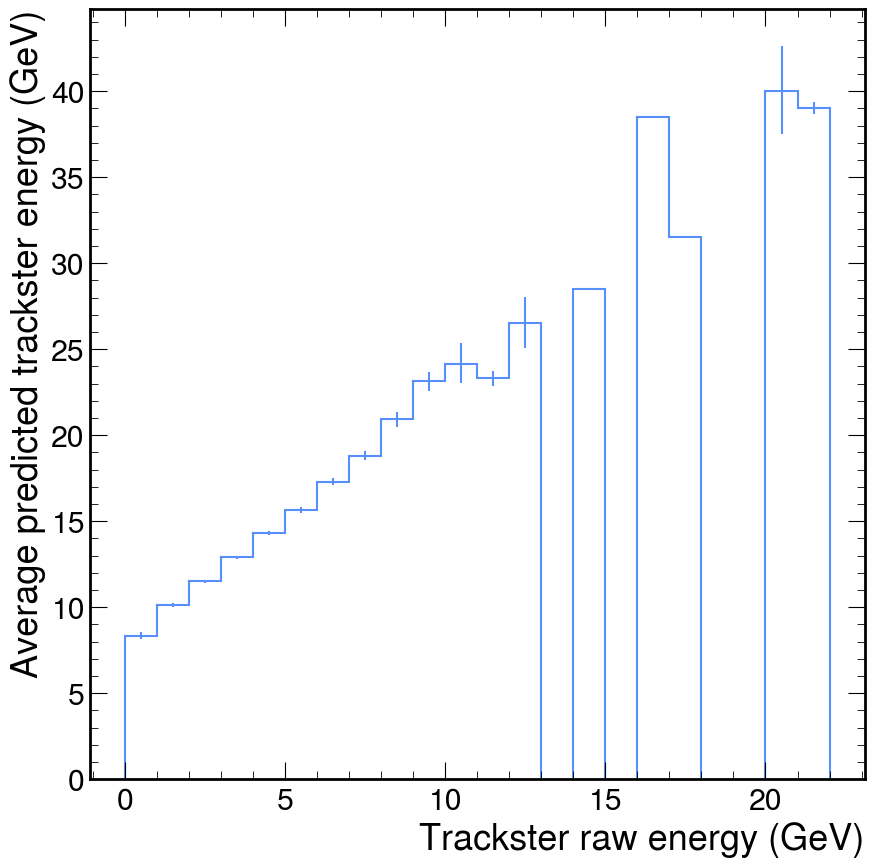

In [5]:
for plotFct in plotsToSave:
    plotFct(hists[0])

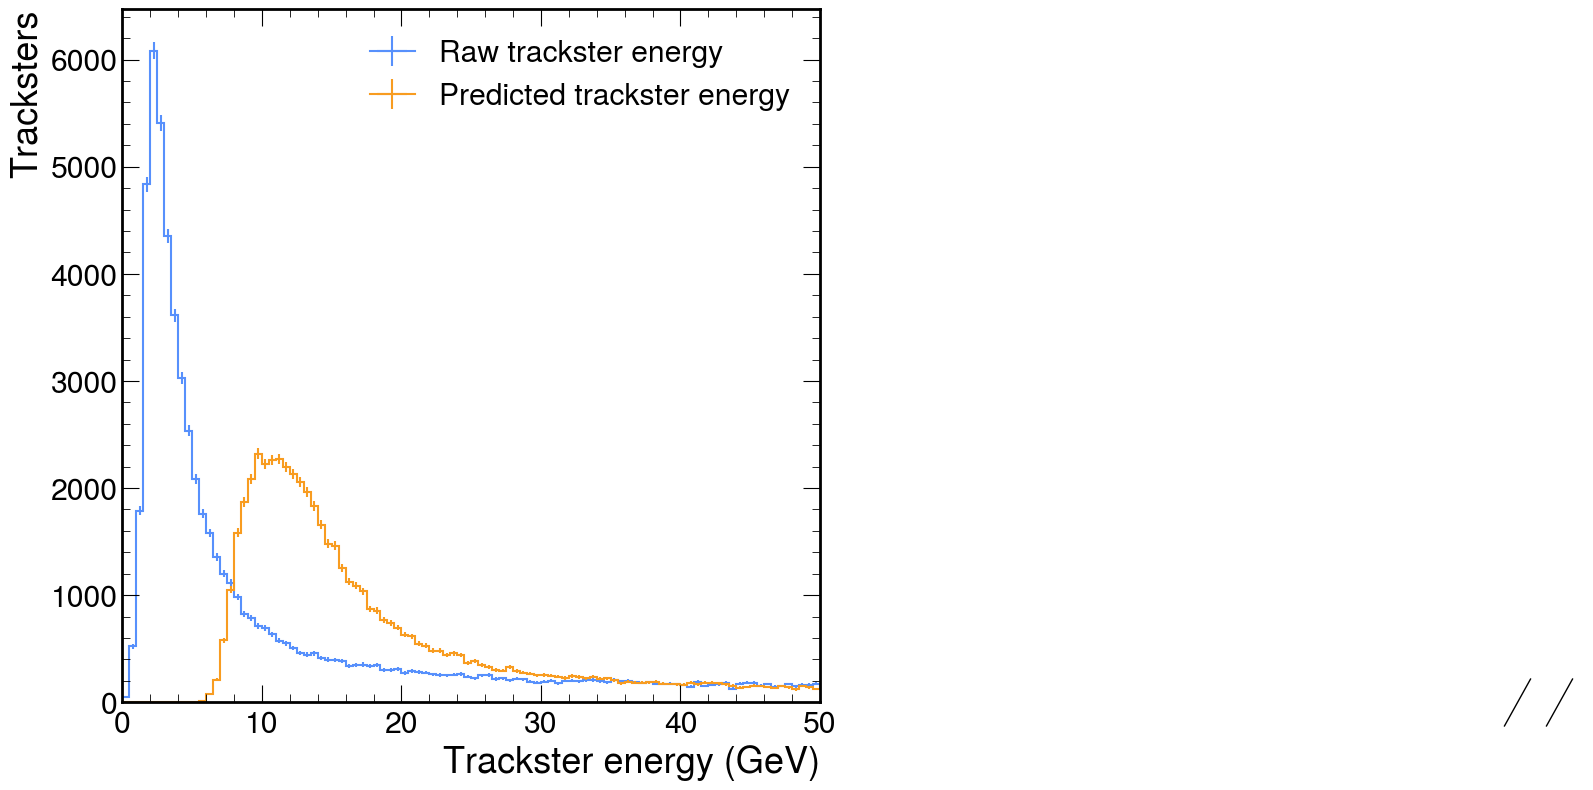

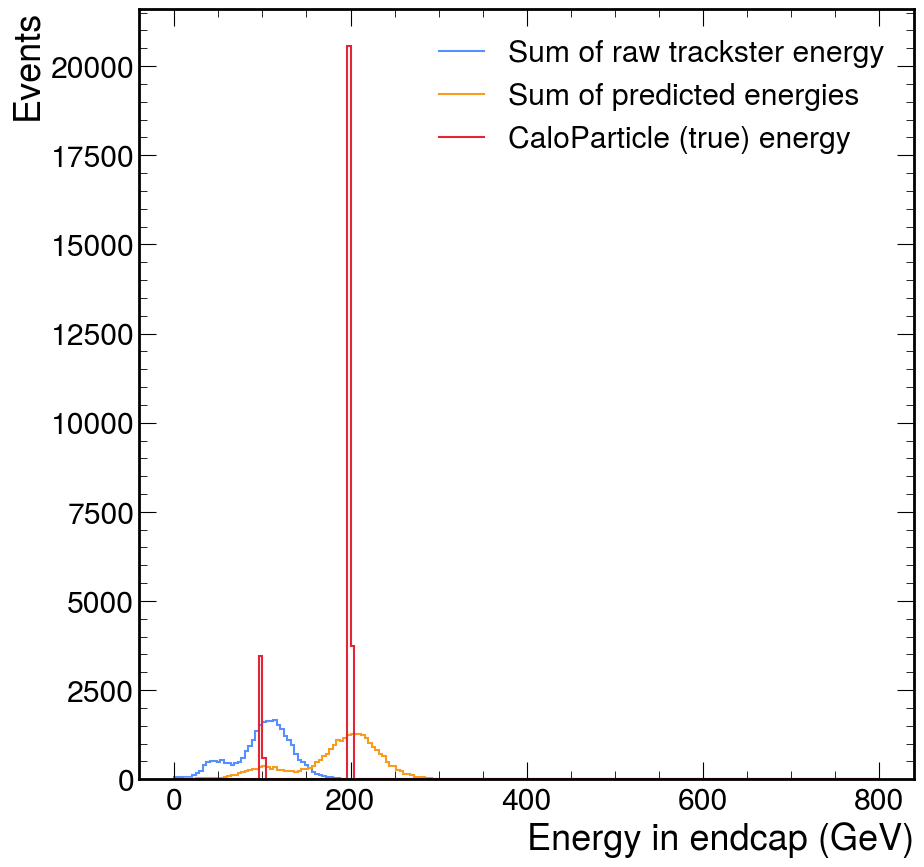

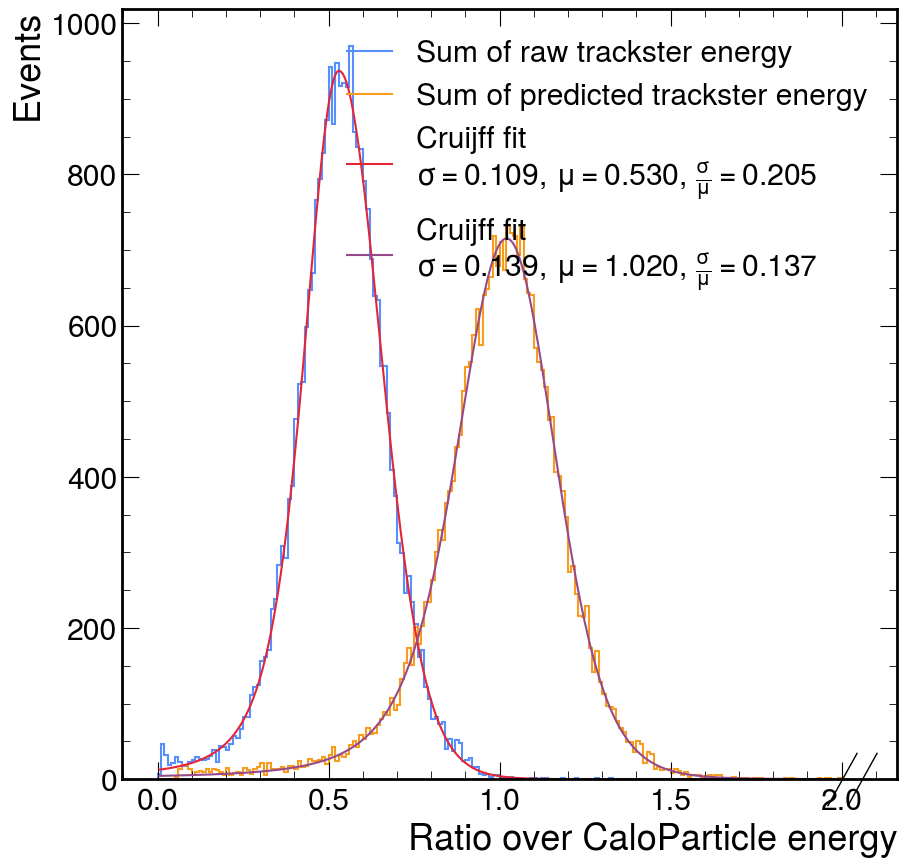

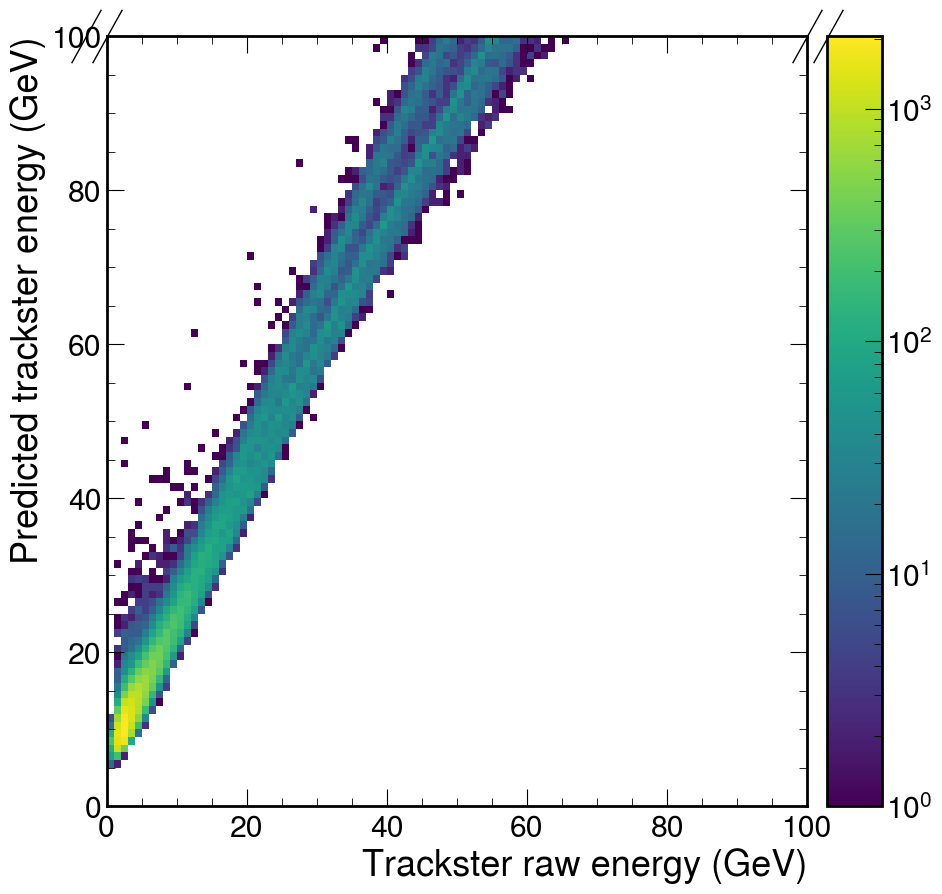

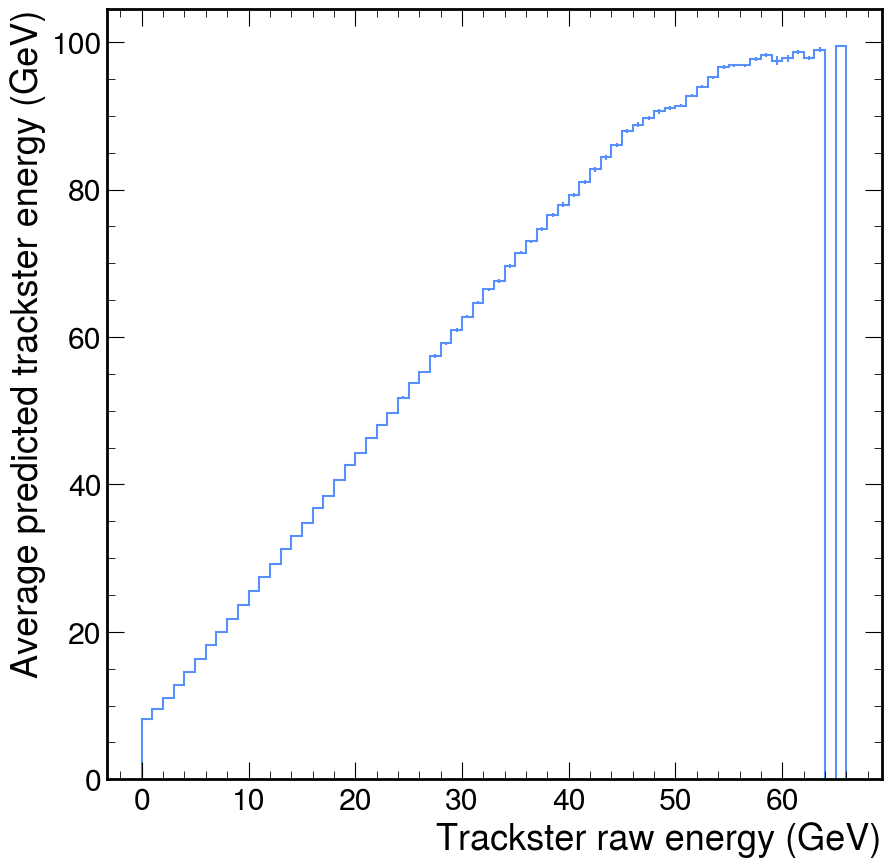

In [7]:
for plotFct in plotsToSave:
    plotFct(hists[1])

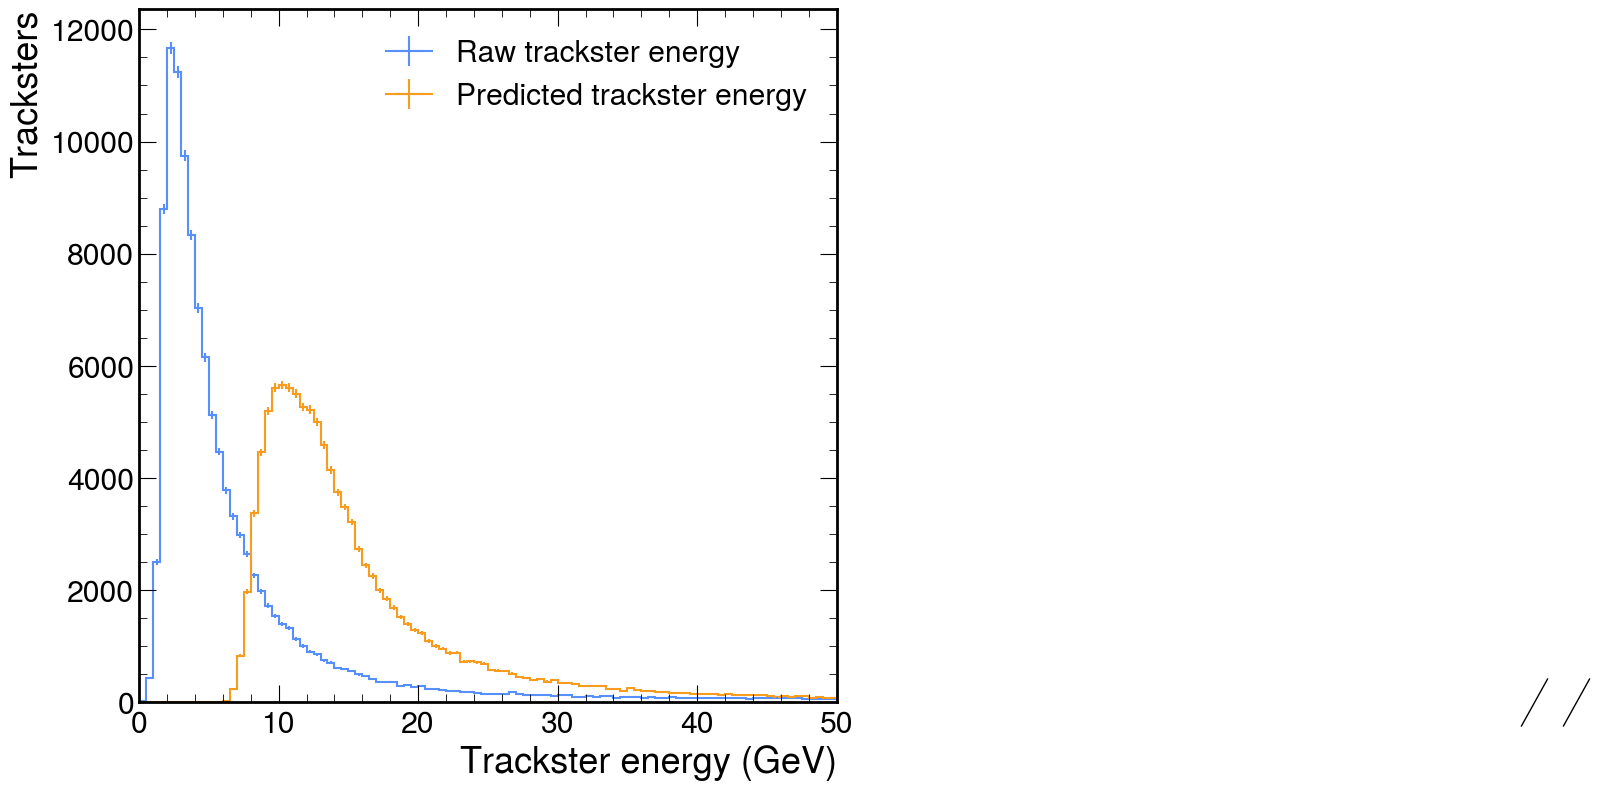

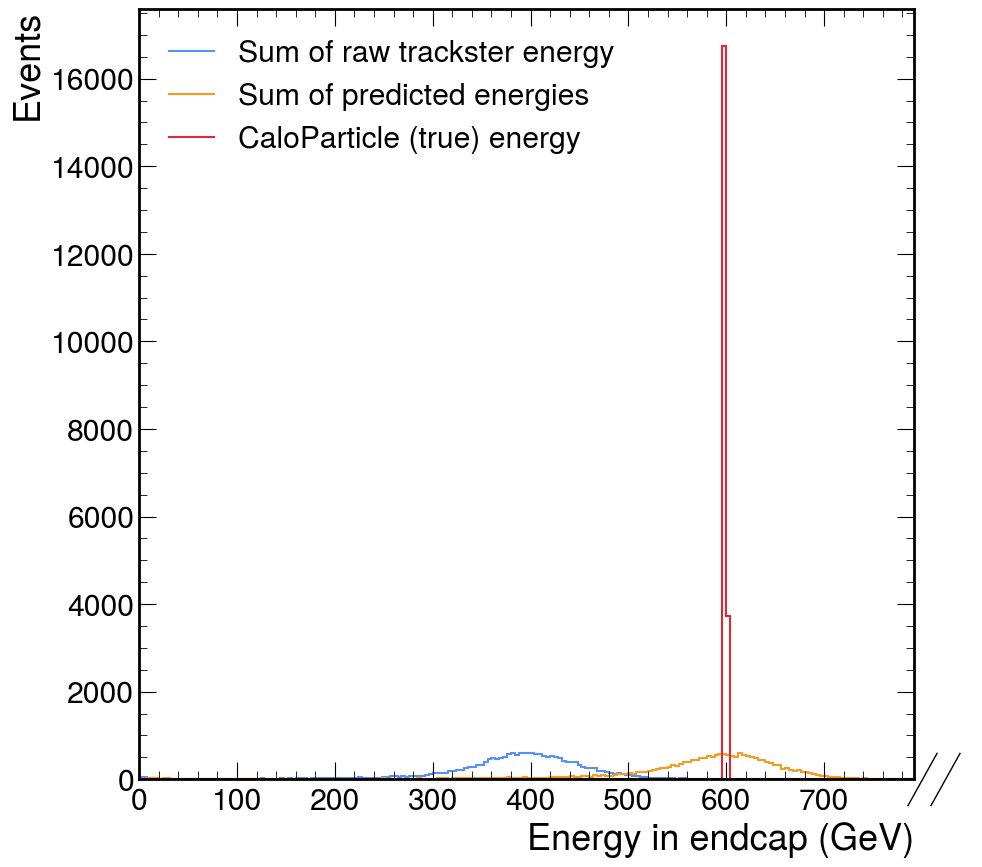

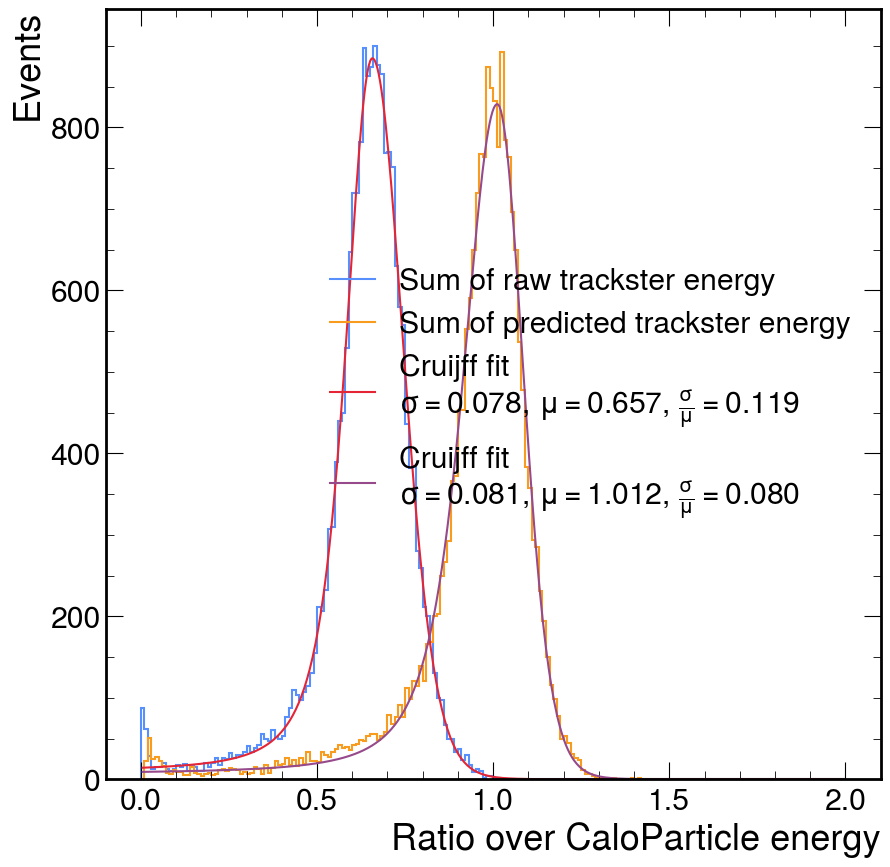

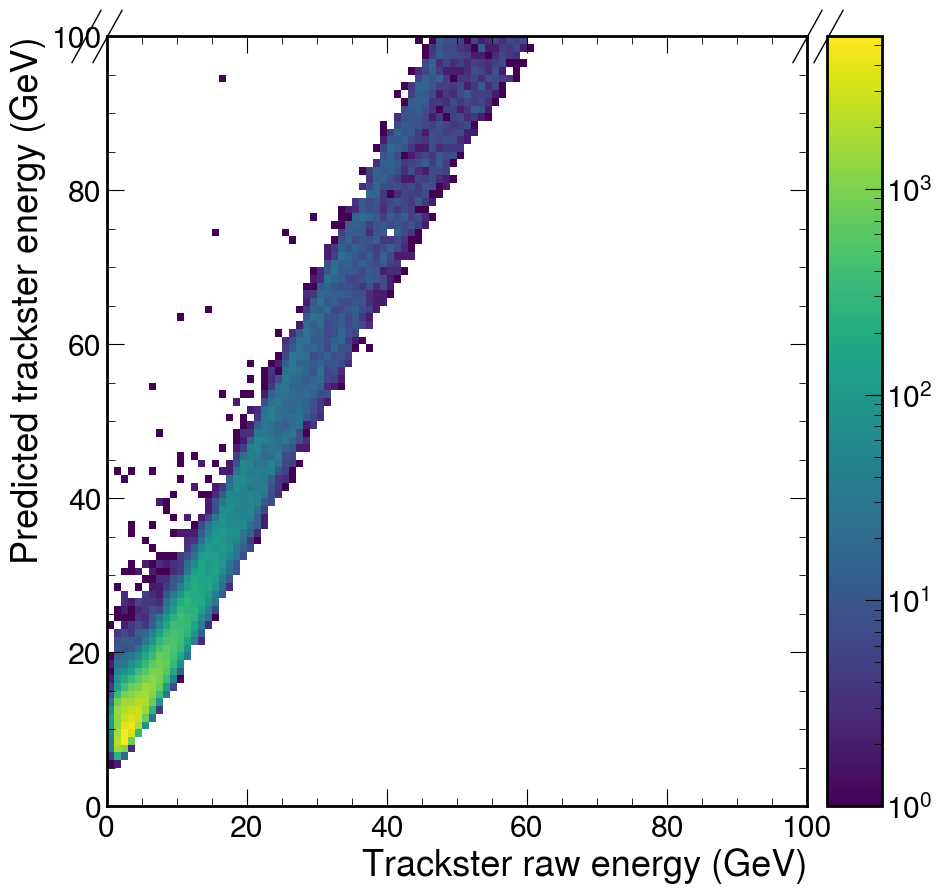

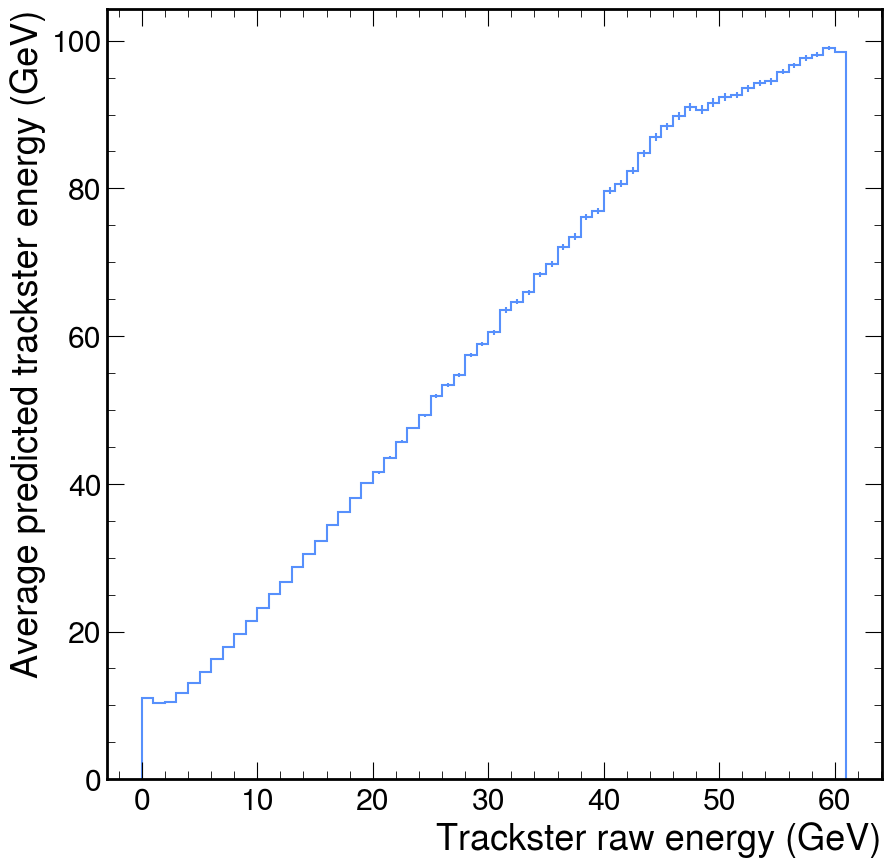

In [20]:
for plotFct in plotsToSave:
    plotFct(hists[-1])

/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlRegression/dnn/../dnn/fit.py:45: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)
/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlRegression/dnn/../dnn/fit.py:50: OptimizeWarning: Covariance of the parameters could not be estimated
  param_optimised,param_covariance_matrix = curve_fit(cruijff, h_forFit.axes[0].centers, h_forFit.values(),


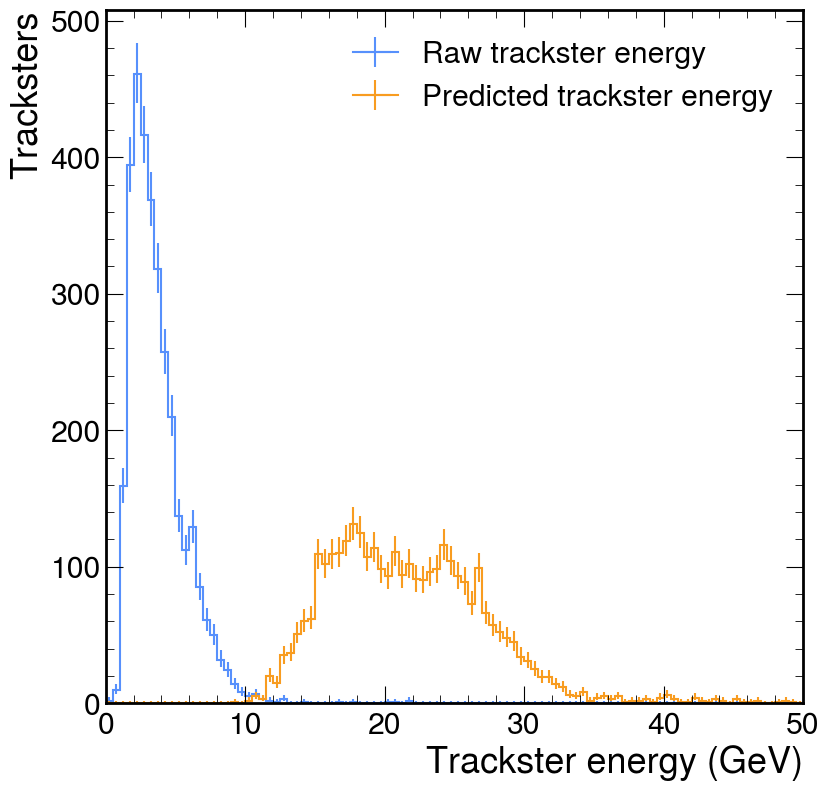

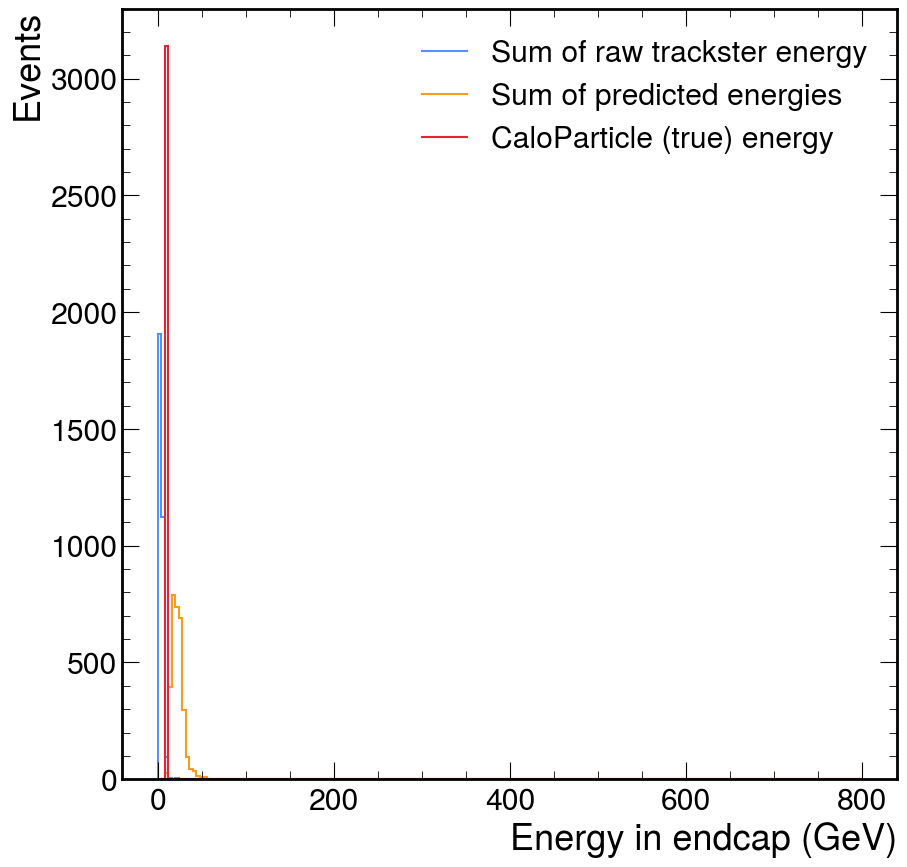

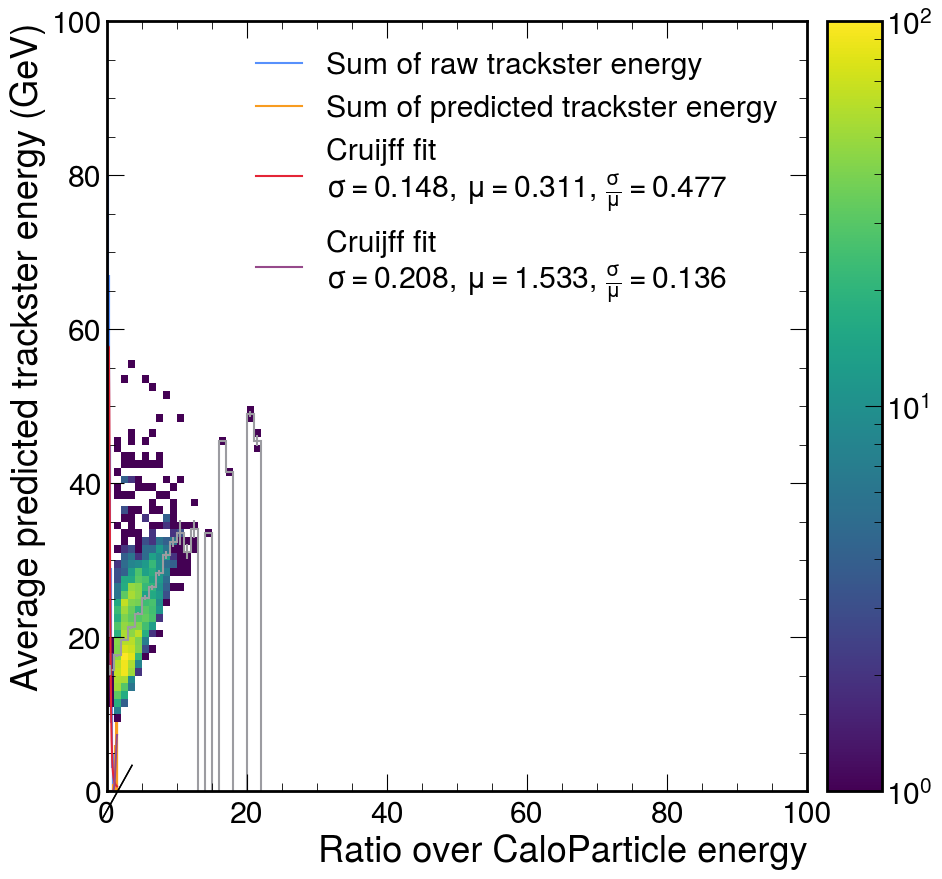

In [8]:
for hists_ in hists:
    for plotFct in plotsToSave:
        plotFct(hists_)

## Comparing with tracksters CLUE3D regressed_energy

In [32]:
energy_i = 1
input = input_samples[energy_i]
h_reco_tot_over_cp = hist.Hist(hist.axis.Regular(200, 0., 2, name="reco_tot_over_cp", label="Total trackster raw energy / CaloParticle energy"))
h_reco_tot_over_cp.fill(ak.sum(input.tracksters_splitEndcaps.regressed_energy, axis=-1) / input.caloparticles_splitEndcaps.regressed_energy)

Hist(Regular(200, 0, 2, name='reco_tot_over_cp', label='Total trackster raw energy / CaloParticle energy'), storage=Double()) # Sum: 19212.0

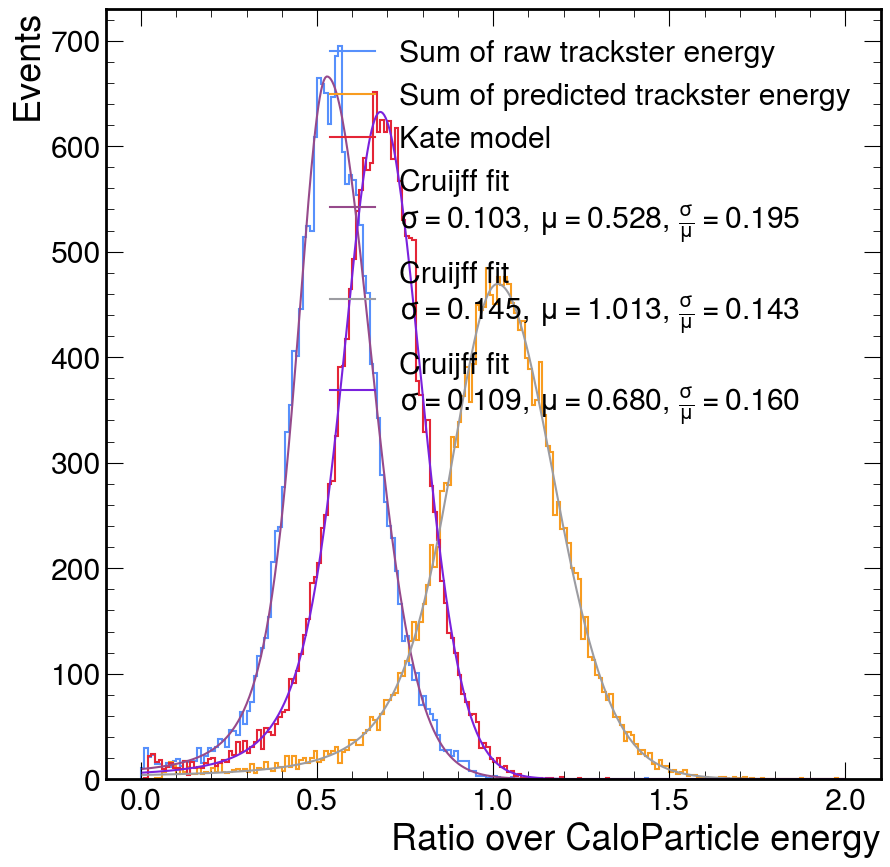

In [33]:

plt.figure()
hep.histplot([hists[energy_i]["h_reco_tot_over_cp"], hists[energy_i]["h_pred_tot_over_cp"], h_reco_tot_over_cp], yerr=False, label=["Sum of raw trackster energy", "Sum of predicted trackster energy", "Kate model"])

def plotFit(h:hist.Hist):
    fitRes = fitCruijff(h)
    params = fitRes.params
    x_plotFct = np.linspace(h.axes[0].centers[0], h.axes[0].centers[-1],500)
    plt.plot(x_plotFct,cruijff(x_plotFct,*params.makeTuple()), 
        label=f"Cruijff fit\n$\sigma={(params.sigmaL+params.sigmaR)/2:.3f}$, $\mu={params.m:.3f}$, " +r"$\frac{\sigma}{\mu}=" + f"{(params.sigmaL+params.sigmaR)/(2*params.m):.3f}$")

try:
    plotFit(hists[energy_i]["h_reco_tot_over_cp"])
    plotFit(hists[energy_i]["h_pred_tot_over_cp"])
    plotFit(h_reco_tot_over_cp)
except (ZeroDivisionError, RuntimeError) as e:
    print("Cruijff fit failed")
    print(e)

plt.ylabel("Events")
plt.xlabel("Ratio over CaloParticle energy")
plt.legend()